<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LSTM-model" data-toc-modified-id="LSTM-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LSTM model</a></span></li><li><span><a href="#GRU-model" data-toc-modified-id="GRU-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GRU model</a></span></li></ul></div>

# Прогнозирование стоимости акций компании Apple с помощью рекуррентных блоков LSTM и GRU

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_datareader import DataReader


import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
#from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import yfinance as yf

In [10]:
# Считаем данные
start = '2014-01-01'
end = '2024-10-01'
symbol = 'AAPL'
company = 'Apple'
stock_data = yf.Ticker(symbol)
stock_data = stock_data.history(start=start, end=end)


In [11]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-02 00:00:00-05:00,17.313752,17.355814,17.199714,17.234299,234684800,0.0,0.0
2014-01-03 00:00:00-05:00,17.225883,17.252054,16.838591,16.855728,392467600,0.0,0.0
2014-01-06 00:00:00-05:00,16.745751,17.037075,16.625793,16.947653,412610800,0.0,0.0
2014-01-07 00:00:00-05:00,16.959798,17.010896,16.760388,16.826443,317209200,0.0,0.0
2014-01-08 00:00:00-05:00,16.788118,16.998433,16.784380,16.933002,258529600,0.0,0.0


In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2704 entries, 2014-01-02 00:00:00-05:00 to 2024-09-30 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2704 non-null   float64
 1   High          2704 non-null   float64
 2   Low           2704 non-null   float64
 3   Close         2704 non-null   float64
 4   Volume        2704 non-null   int64  
 5   Dividends     2704 non-null   float64
 6   Stock Splits  2704 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 169.0 KB


In [13]:
# Отсортируем индексы в хронологическом порядке

stock_data.sort_index(inplace = True)
print('Минимальная дата', stock_data.index.min())
print('Максимальная дата', stock_data.index.max())


Минимальная дата 2014-01-02 00:00:00-05:00
Максимальная дата 2024-09-30 00:00:00-04:00


In [14]:
# Удалим столбцы с объемом продаж, цене открытия, самой высокой и низкой ценой, дивидентах
stock_data.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis = 1, inplace = True)

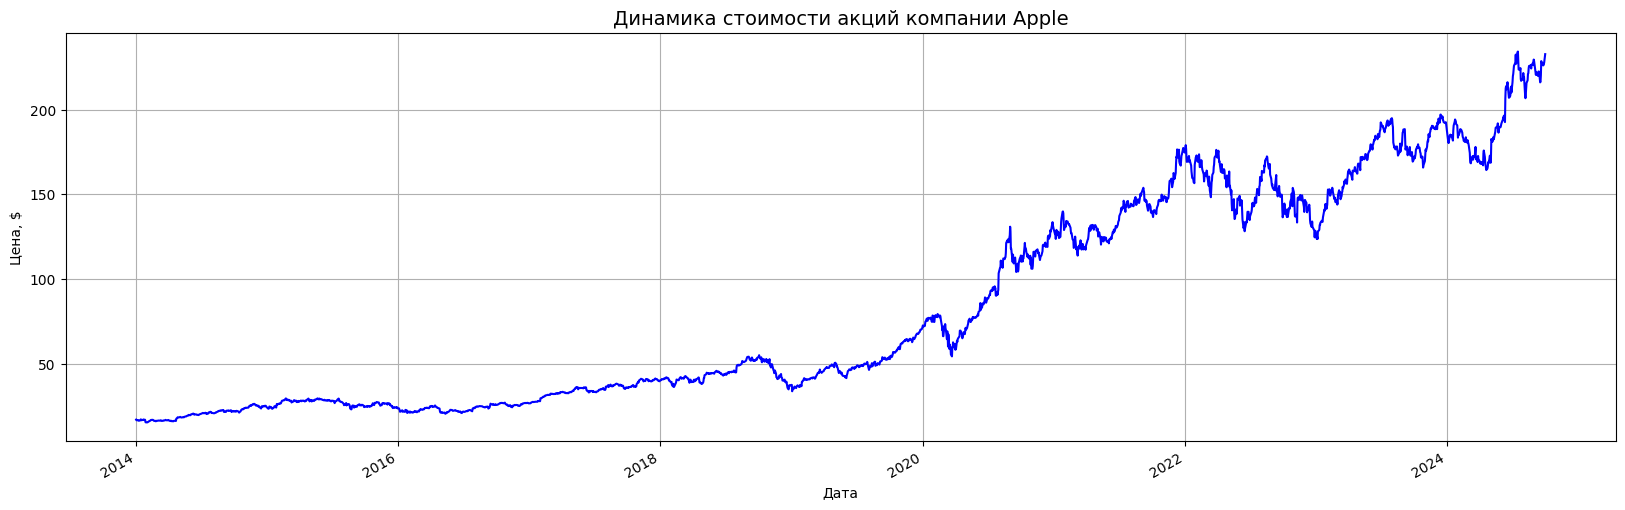

In [15]:
# Построим график данных

stock_data['Close'].plot(color = 'blue', figsize=(20, 6))
plt.title('Динамика стоимости акций компании '+company, fontsize = 14)
plt.xlabel('Дата')
plt.ylabel('Цена, $')
#plt.legend(loc = 'best')
plt.grid()
plt.show()

Найдем скользящее среднее и скользящее стандартное отклонение по ширине окна 28 дней

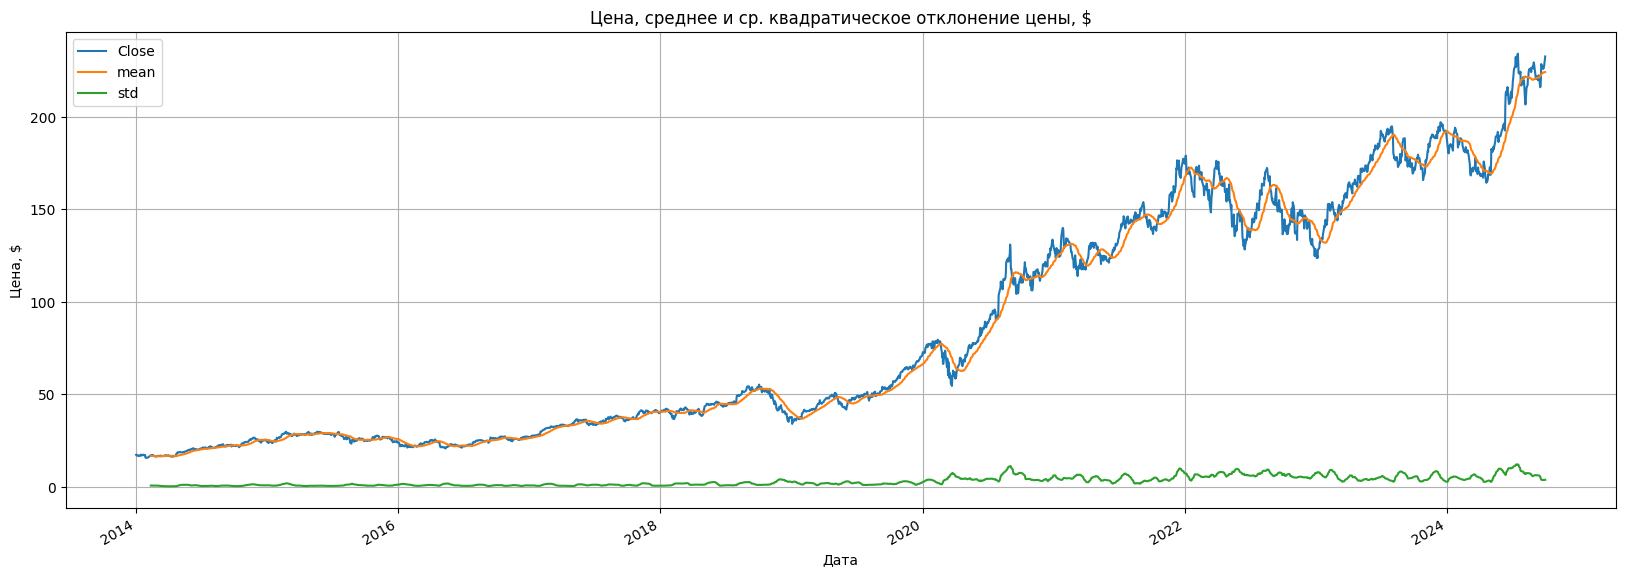

In [16]:
stock_data['mean'] = stock_data['Close'].shift().rolling(28).mean()
stock_data['std'] = stock_data['Close'].shift().rolling(28).std()

stock_data.plot(figsize = (20, 7))
plt.title('Цена, среднее и ср. квадратическое отклонение цены, $')
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.grid()
plt.show()

Рассмотрим первые разности временного ряда и изобразим его скользящее среднее и скользящее стандартное отклонение.

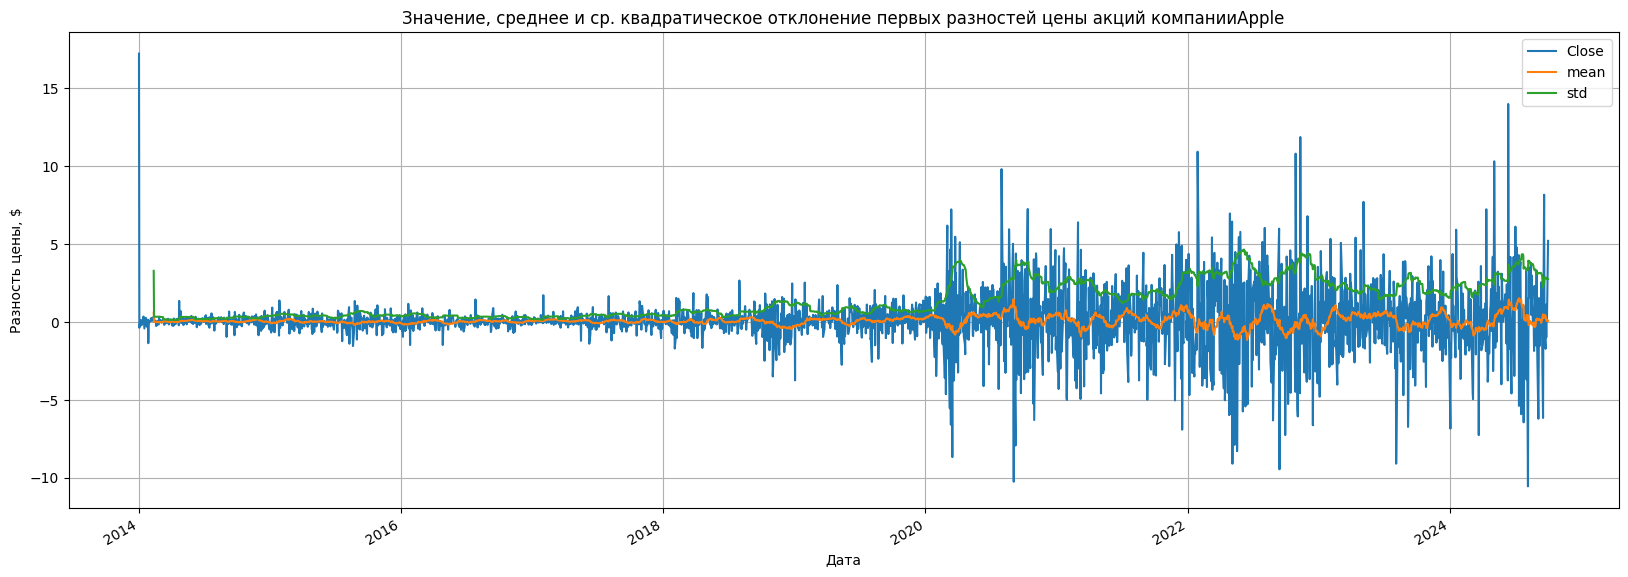

In [17]:
df_shift = stock_data - stock_data.shift(fill_value=0)

df_shift['mean'] = df_shift['Close'].shift().rolling(28).mean()
df_shift['std'] = df_shift['Close'].shift().rolling(28).std()

df_shift.plot(figsize = (20, 7))
plt.title('Значение, среднее и ср. квадратическое отклонение первых разностей цены акций компании' +company)
plt.xlabel('Дата')
plt.ylabel('Разность цены, $')
plt.grid()
plt.show()

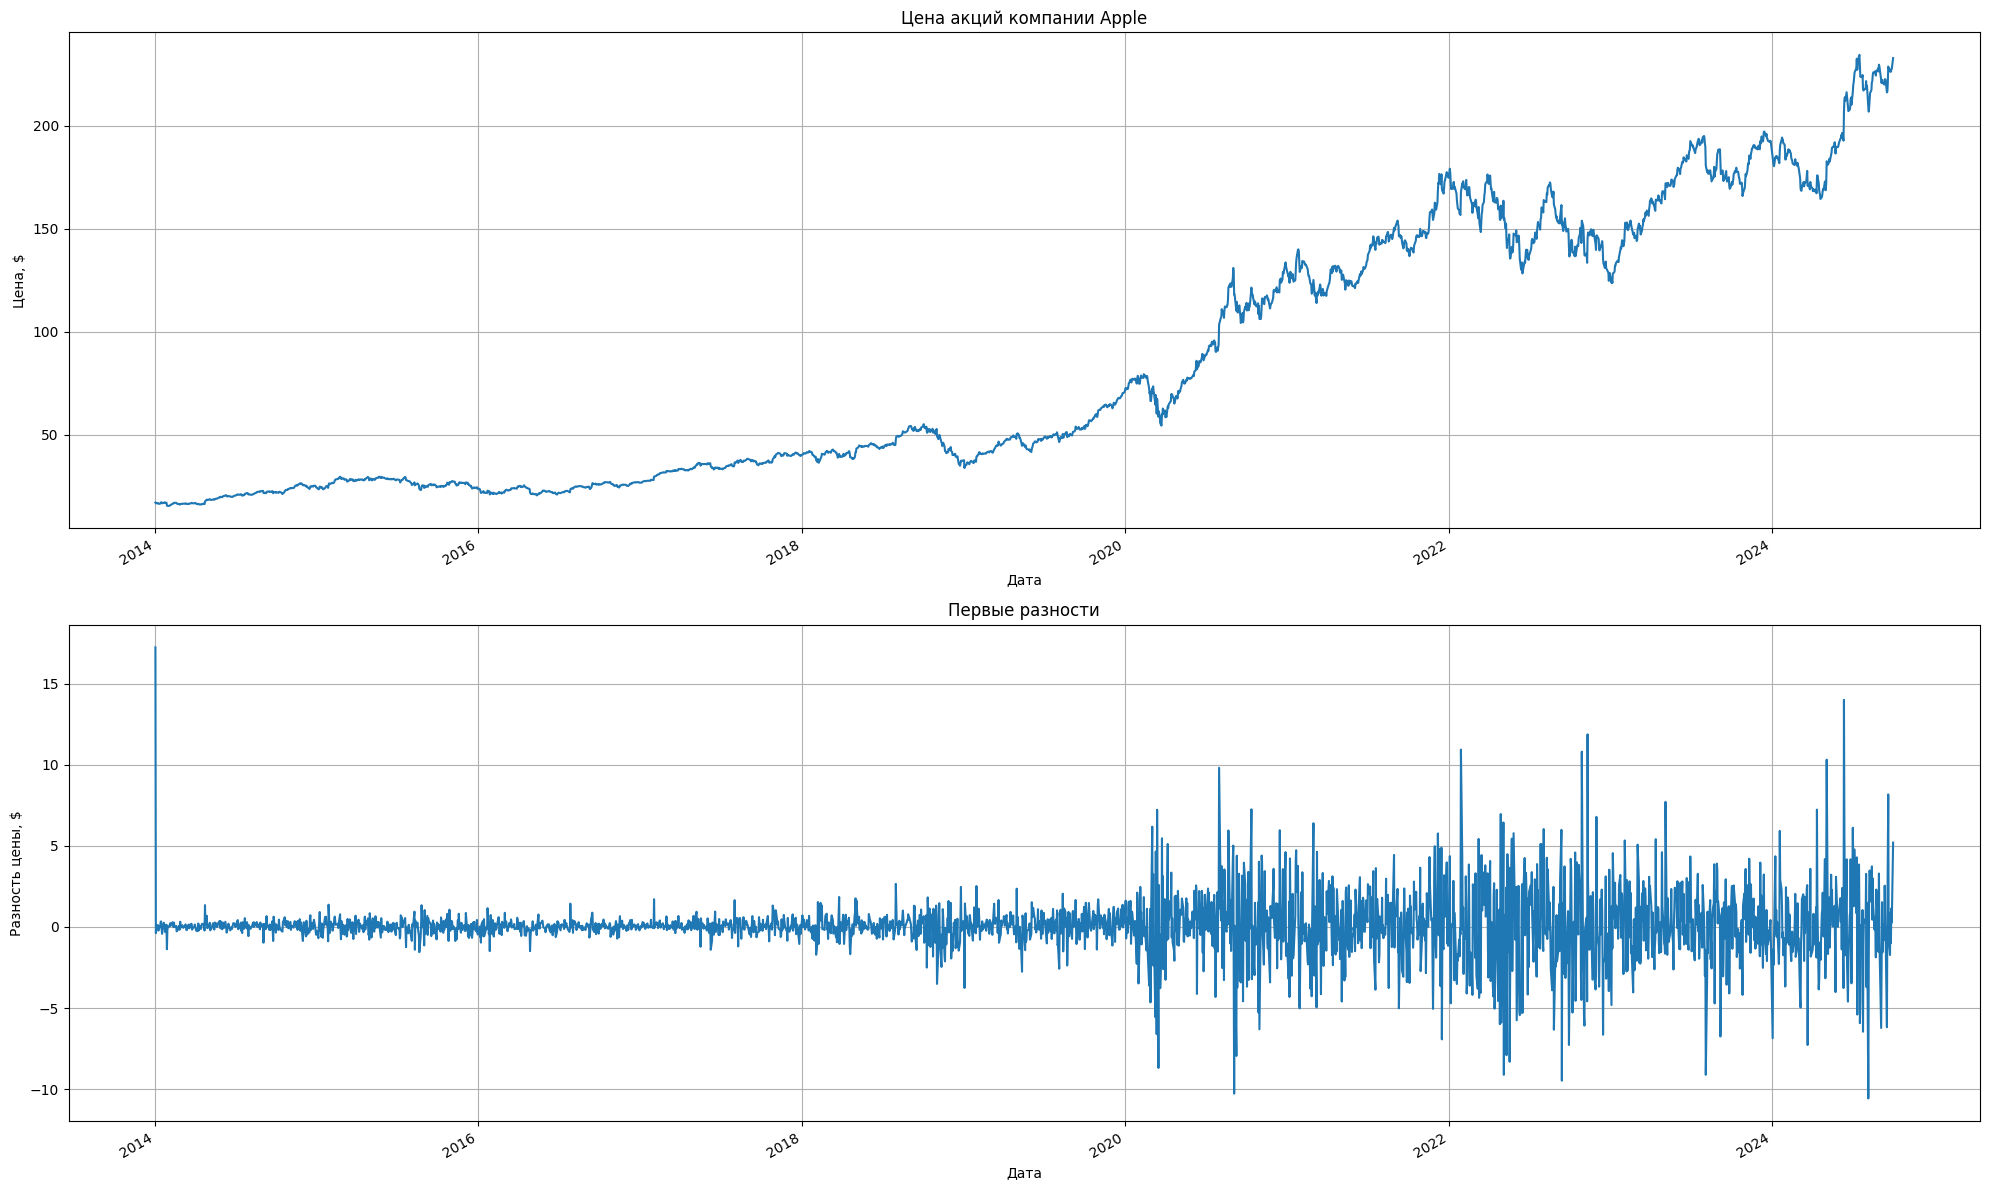

In [18]:
# Построим график исходного временного ряда и ряд его первых разностей
plt.figure(figsize=(20, 12))
plt.subplot(211)
stock_data['Close'].plot(ax = plt.gca())
plt.title('Цена акций компании '+company)
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.grid()

plt.subplot(212)
df_shift['Close'].plot(ax = plt.gca())
plt.title('Первые разности')
plt.xlabel('Дата')
plt.ylabel('Разность цены, $')
plt.grid()

plt.tight_layout()

Построим автокорреляционную функцию и проведем тест Дики-Фуллера.

<Figure size 1200x700 with 0 Axes>

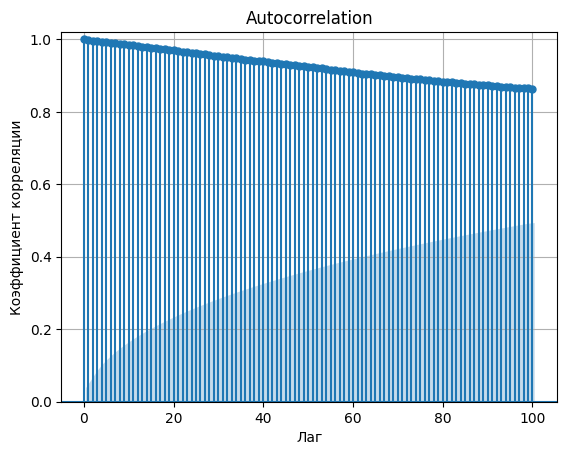

In [19]:
plt.figure(figsize=(12, 7))
plot_acf(stock_data['Close'], lags = 100)
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
plt.ylim([0, 1.02])
plt.grid()
plt.show()

In [20]:
test = adfuller(stock_data['Close'], regression = 'ct')
print('adf:',test[0])
print('p-value:',test[1])
print('critical values:',test[4])

if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен при 5% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 5% уровне значимости')

if test[0]> test[4]['1%']:
    print('есть единичные корни, ряд не стационарен при 1% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 1% уровне значимости')

adf: -1.9118153889717393
p-value: 0.6485245415483503
critical values: {'1%': -3.9621343915453595, '5%': -3.4121209429740773, '10%': -3.1280103043893837}
есть единичные корни, ряд не стационарен при 5% уровне значимости
есть единичные корни, ряд не стационарен при 1% уровне значимости


In [21]:
stock_data.shape

(2704, 3)

Подготовим данные для обучения сети. Разделим данные на тренировочные и тестовые. Выполним минимаксное преобразование.

In [22]:
stock_data.reset_index(inplace = True)
stock_data['Date']= pd.to_datetime(stock_data['Date']).dt.date


In [23]:
#Data Preprocessing

num_shape = 2400

train = stock_data.iloc[:num_shape, 1:2].values
test = stock_data.iloc[num_shape:, 1:2].values

In [24]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)


In [25]:
X_train = []

# Цена на следующий день
y_train = []

# Выбираем ширину окна, т.е. длину входного вектора
window = 30

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)
X_train.shape

(2370, 30, 1)

## LSTM model

In [26]:
# Initializing the Recurrent Neural Network
model = tensorflow.keras.Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 36, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 36, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 36, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 36)         │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 36)         │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 36)         │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,947 (171.67 KB)

 Trainable params: 43,947 (171.67 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

In [28]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model.fit(X_train, y_train, epochs = 40, batch_size = 64, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0517 - mae: 0.1507
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0048 - mae: 0.0446
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0029 - mae: 0.0328
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027 - mae: 0.0318
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0030 - mae: 0.0342
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0025 - mae: 0.0307
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0025 - mae: 0.0302
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0026 - mae: 0.0323
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0022 - mae: 0.0286
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0022 - mae: 0.0290
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0024 - mae: 0.0296
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0030 - mae: 0.0345
Epoch 13/40
38/38 ━━━━━━━━━━━━━━━━━━

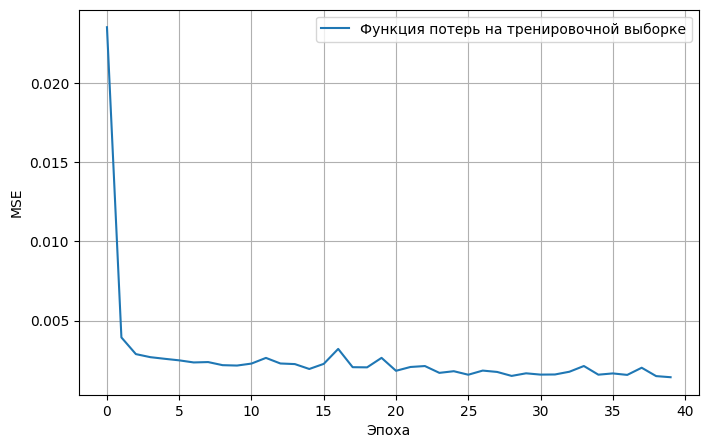

In [29]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['loss'], label='Функция потерь на тренировочной выборке')
#plt.plot(hist.history['val_loss'], label='Функция потерь на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

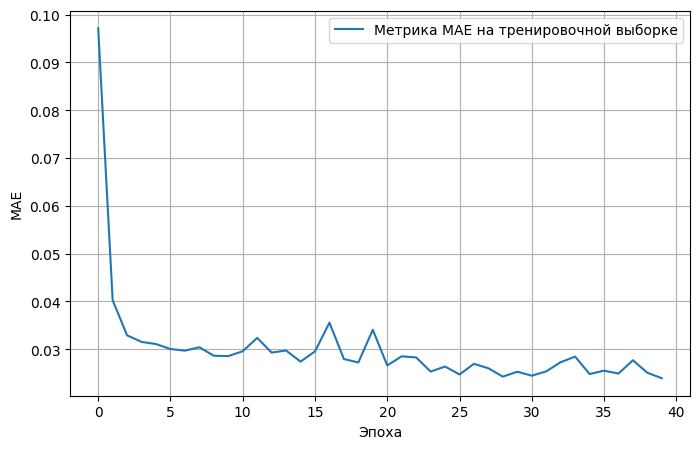

In [30]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['mae'], label='Метрика MAE на тренировочной выборке')
#plt.plot(hist.history['val_mae'], label='Метрика MAE на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


Объединим обучающую и тестовые выборки в один массив.

In [31]:
#
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)

X_test = np.stack(X_test)

Строим прогноз моделью и возвращаемся к исходному масштабу данных.

In [32]:
predict_LSTM = model.predict(X_test)
predict_LSTM = scaler.inverse_transform(predict_LSTM)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


In [33]:
#Metrics

print('MAE', mean_absolute_error(test, predict_LSTM))
print('MAPE', mean_absolute_percentage_error(test, predict_LSTM))
print('MSE', mean_squared_error(test, predict_LSTM))
print('RMSE', np.sqrt(mean_squared_error(test, predict_LSTM)))

MAE 7.746125723186292
MAPE 0.03874830865483531
MSE 98.86858579396855
RMSE 9.943268365782377


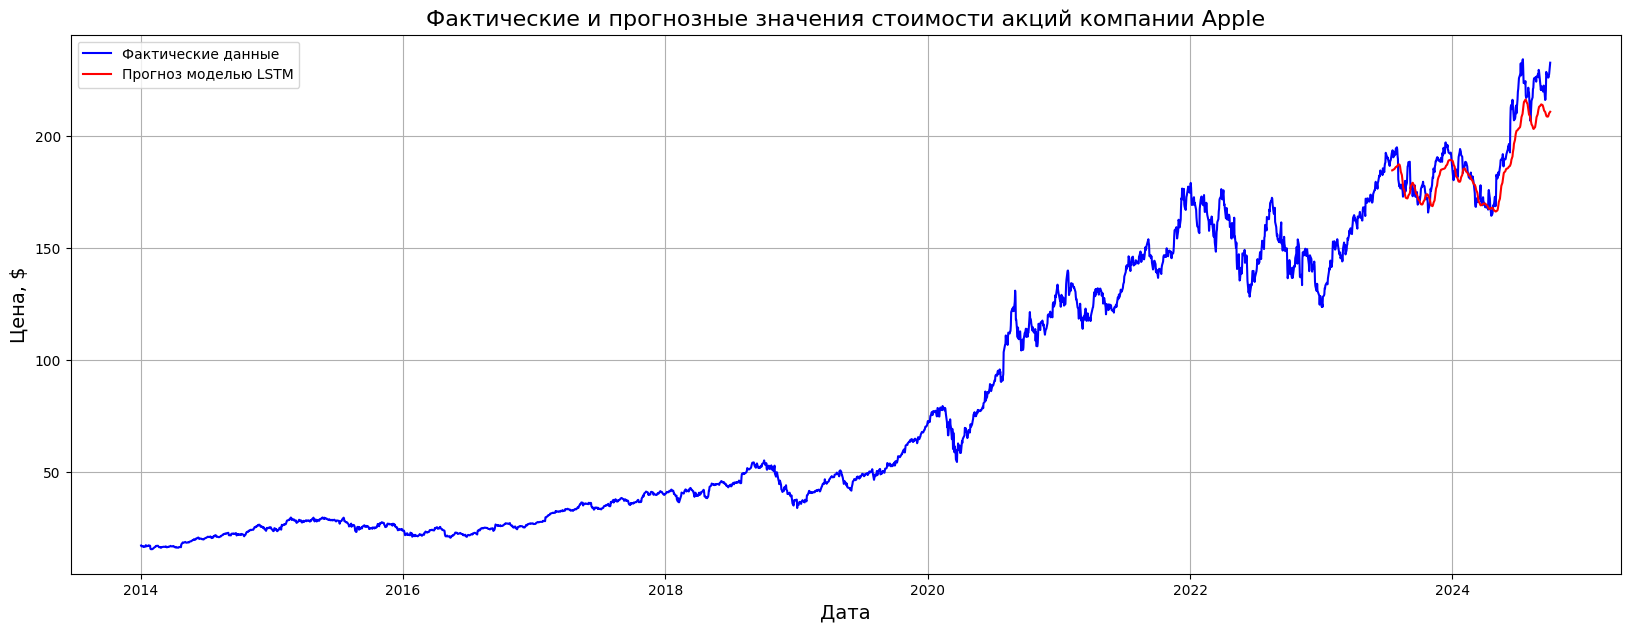

In [34]:
plt.figure(figsize=(20,7))
plt.plot(stock_data['Date'].values, df_volume, color = 'blue', label='Фактические данные')
plt.plot(stock_data['Date'][-predict_LSTM.shape[0]:].values, predict_LSTM, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании '+company, fontsize = 16)
plt.show()

In [35]:
# Прогноз на 5 дней вперед

horizon = 5
pred_ = predict_LSTM[-1].copy()
prediction_full = []
window = 30
df_copy = stock_data.iloc[:, 1:2][1:].values

for j in range(horizon):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]

    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = scaler.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = scaler.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [36]:
prediction_full

[211.56277, 211.56277, 212.13521, 211.20108, 203.23807]

In [37]:
prediction_full_new = np.vstack((predict_LSTM, np.array(prediction_full).reshape(-1,1)))

In [ ]:
# Формируем столбец с новыми датами
df_date = stock_data[['Date']]

for h in range(horizon):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add], columns=['Date'])
    df_date = pd.concat([df_date, df_date_add], axis = 0)
df_date = df_date.reset_index(drop=True)

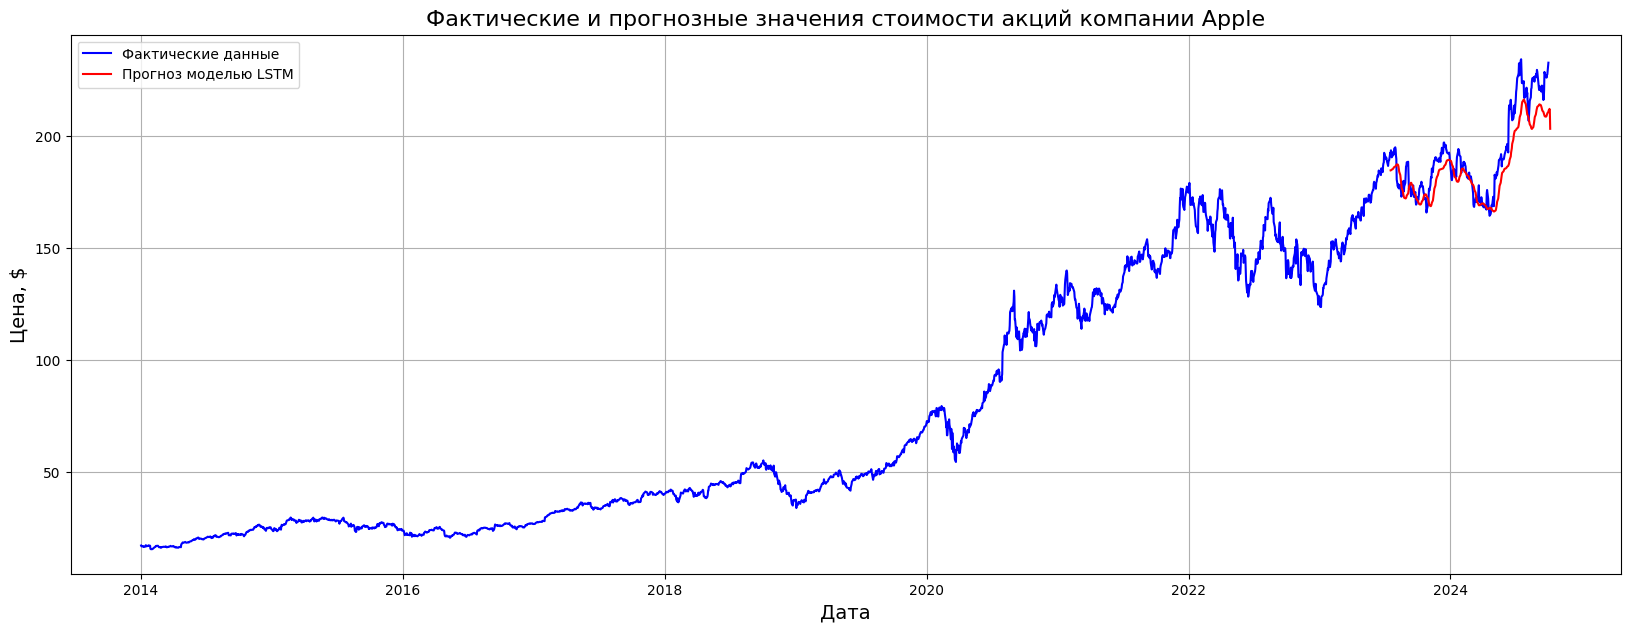

In [39]:
# Построим графики фактических данных и результатов прогноза для тестовой выборки
plt.figure(figsize=(20,7))
plt.plot(stock_data['Date'].values, df_volume, color = 'blue', label='Фактические данные')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании '+company, fontsize = 16)
plt.show()

## Задание для самостоятельного выполнения

1. Выберите произвольную компанию и соберите данные дневных стоимостей акций этой компании за период не менее 10 лет.
2. Постройте прогноз стоимости акций компании на ближайшую торговую неделю (5 дней) с помощью рекуррентных моделей GRU и LSTM. Подберите наиболее подходящую ширину окна, число нейронов рекуррентных блоков и количество рекуррентных блоков сети.
3. Для построенных моделей рассчитайте ключевые метрики, сравните результаты и выберите "лучшую" модель.

# Считаем данные
start = '2014-01-01'
end = '2024-10-01'
symbol = 'AAPL'
company = 'Apple'
stock_data = yf.Ticker(symbol)
stock_data = stock_data.history(start=start, end=end)